In [64]:

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import defaultdict
from pylab import rcParams
from transformers import AutoTokenizer, DistilBertForSequenceClassification
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

sns.set()
%matplotlib inline



In [65]:
!pip install wordcloud

In [66]:
# !pip install wandb

In [67]:
# import wandb

In [68]:
!pip install nlpaug


In [69]:
!pip install bertopic

In [70]:
# Path to save the trained model in the /kaggle/working/ directory
output_model_path = "/kaggle/working/best_model_state.bin"

# **1. Exploring Data**


In [71]:

train_df  = pd.read_csv("/train.csv")

In [72]:
train_df.shape 

(7613, 5)

In [73]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [74]:
train_df["text"].iloc[2]

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

In [75]:
for i, text in enumerate(train_df['text'][:10]):
    print(f'text #{i}')
    print(text + '\n')

text #0
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

text #1
Forest fire near La Ronge Sask. Canada

text #2
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected

text #3
13,000 people receive #wildfires evacuation orders in California 

text #4
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 

text #5
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires

text #6
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas

text #7
I'm on top of the hill and I can see a fire in the woods...

text #8
There's an emergency evacuation happening now in the building across the street

text #9
I'm afraid that the tornado is coming to our area...



In [76]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [77]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

<Axes: xlabel='text_len', ylabel='Count'>

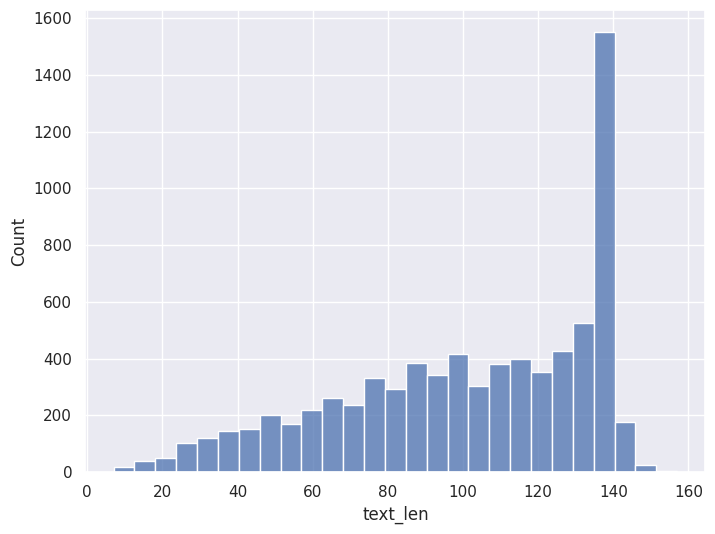

In [78]:
train_df['text_len'] = train_df['text'].apply(len)
sns.histplot(train_df['text_len'], kde=False)

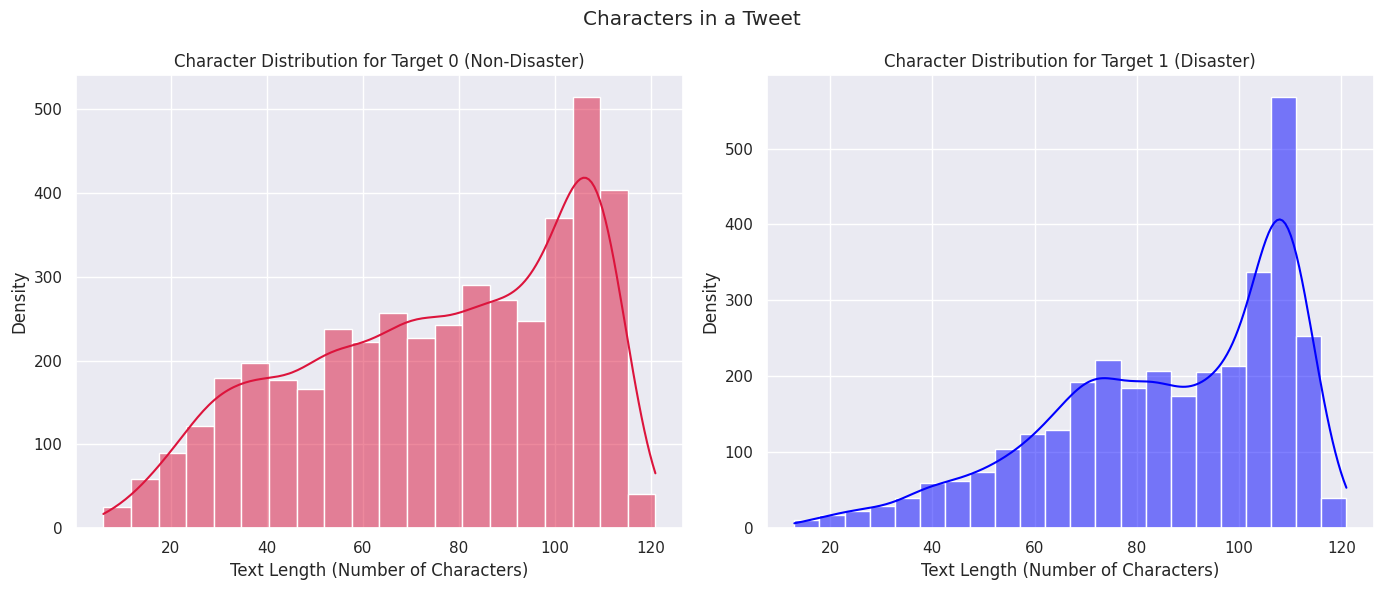

In [79]:
target_0_text = train_df[train_df['target'] == 0]['text']
target_1_text = train_df[train_df['target'] == 1]['text']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

def create_char_distribution_histogram(text, target_name, ax):
    text = text.str.replace(r'\W', ' ', regex=True)  
    text = text.str.lower()  
    text = text.str.replace(' ', '')  
    text_length = text.str.len()
    
    sns.histplot(text_length, kde=True, color='blue' if target_name == '1 (Disaster)' else 'crimson', ax=ax)
    
    ax.set_xlabel('Text Length (Number of Characters)')
    ax.set_ylabel('Density')
    ax.set_title(f'Character Distribution for Target {target_name}')

create_char_distribution_histogram(target_0_text, '0 (Non-Disaster)', ax1)
create_char_distribution_histogram(target_1_text, '1 (Disaster)', ax2)

plt.suptitle('Characters in a Tweet')
plt.tight_layout()
plt.show()

In [80]:
from sklearn.model_selection import train_test_split



# Split into 80% training and 20% remaining (validation + test)
train_df, remaining = train_test_split(train_df, test_size=0.2, random_state=RANDOM_SEED, stratify=train_df['target'])

# Split the remaining into 50% validation and 50% test
valid_df, test_df = train_test_split(remaining, test_size=0.5, random_state=RANDOM_SEED, stratify=remaining['target'])




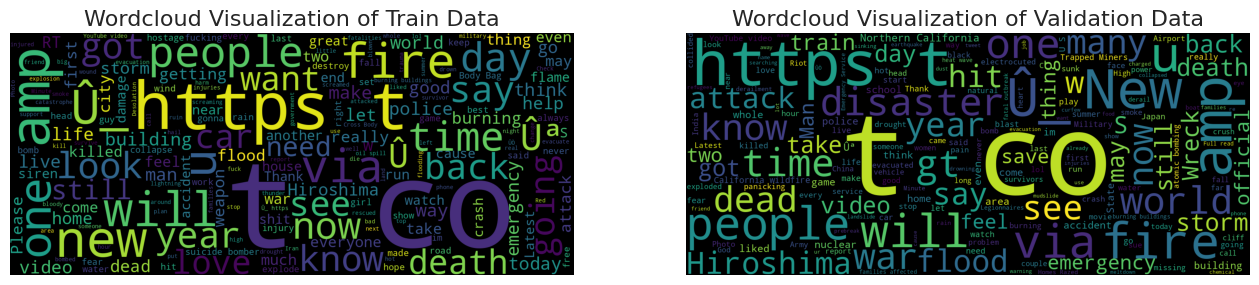

In [81]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def generate_and_display_wordcloud(data, title, ax):
    wordcloud = WordCloud(width=1400, height=600, background_color='black').generate(''.join(text for text in data['text']))
    
    ax.imshow(wordcloud)
    ax.set_title(f'Wordcloud Visualization of {title}', fontsize=16)
    ax.axis('off')
    
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

generate_and_display_wordcloud(train_df, 'Train Data', axs[0])
generate_and_display_wordcloud(valid_df, 'Validation Data', axs[1])

plt.show()

Topic Modeling


In [82]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [83]:
import re
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords
import nltk
from bertopic import BERTopic
import random
import nlpaug.augmenter.word as naw

# Get the set of English stop words
stop = set(stopwords.words('english'))

def word_swap(text, p=0.1):
    # Introduce noise (word swapping) to the text
    words = word_tokenize(text)
    for i in range(len(words) - 1):
        if random.random() < p:
            words[i], words[i + 1] = words[i + 1], words[i]
    return ' '.join(words)

def tok(context):
    context = str(context).lower()
    context = ' '.join(re.findall("[A-Za-z]{3,}", str(re.sub(r'http\S+', '', str(context)))))
    words = word_tokenize(context)  # Use word_tokenize from nltk.tokenize
    words = [element for element in words if element.isalpha()]  # Keep only alphabetic words
    list_words = [w for w in words if w not in stop]

    # Introduce noise (word swapping) to the list of words
    noisy_words = [word_swap(word) for word in list_words]

    return ' '.join(noisy_words)


train_df['clean'] = train_df['text'].apply(tok)
valid_df['clean'] = valid_df['text'].apply(tok)
test_df['clean'] =test_df['text'].apply(tok)

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
docs = train_df['clean'].tolist()
topics, probs = topic_model.fit_transform(docs)

# Transform the validation set
valid_docs = valid_df['clean'].tolist()
valid_topics, valid_probs = topic_model.transform(valid_docs)
valid_df['Topic'] = valid_topics

# Transform the test set
test_docs = test_df['clean'].tolist()
test_topics, test_probs = topic_model.transform(test_docs)
test_df['Topic'] = test_topics

freq = topic_model.get_topic_info()
freq.head(5)


Batches:   0%|          | 0/191 [00:00<?, ?it/s]

2023-11-24 17:22:17,849 - BERTopic - Transformed documents to Embeddings
2023-11-24 17:22:26,620 - BERTopic - Reduced dimensionality
2023-11-24 17:22:33,743 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
2023-11-24 17:22:38,793 - BERTopic - Reduced dimensionality
2023-11-24 17:22:39,863 - BERTopic - Calculated probabilities with HDBSCAN
2023-11-24 17:22:39,865 - BERTopic - Predicted clusters


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

2023-11-24 17:22:43,330 - BERTopic - Reduced dimensionality
2023-11-24 17:22:44,399 - BERTopic - Calculated probabilities with HDBSCAN
2023-11-24 17:22:44,400 - BERTopic - Predicted clusters


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1849,-1_people_like_amp_get,"[people, like, amp, get, storm, fire, got, lif...",[rly tragedy live recount horror saw coaches t...
1,0,158,0_youtube_liked_video_playlist,"[youtube, liked, video, playlist, music, added...",[added video youtube playlist panic disco girl...
2,1,90,1_mass_murderer_murder_theater,"[mass, murderer, murder, theater, antioch, mas...",[another white mass murderer thank god live ca...
3,2,76,2_hiroshima_atomic_nagasaki_anniversary,"[hiroshima, atomic, nagasaki, anniversary, mar...",[japan marks anniversary hiroshima atomic bomb...
4,3,74,3_screamed_screams_screaming_arianagrande,"[screamed, screams, screaming, arianagrande, j...","[screams, justinbieber arianagrande hear screa..."


In [84]:
freq.head(1)


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1849,-1_people_like_amp_get,"[people, like, amp, get, storm, fire, got, lif...",[rly tragedy live recount horror saw coaches t...


Data Cleaning


In [85]:
train_df.head()

,id,keyword,location,text,target,text_len,clean
6234,8902,snowstorm,"South, USA",Sassy city girl country hunk stranded in Smoky...,1,116,sassy city girl country hunk stranded smoky mo...
326,472,armageddon,Worldwide,God's Kingdom (Heavenly Gov't) will rule over ...,0,135,god kingdom heavenly gov rule people earth arm...
997,1448,body%20bagging,Cloud 9,Mopheme and Bigstar Johnson are a problem in t...,0,86,mopheme bigstar johnson problem game body bagg...
7269,10407,whirlwind,Sheff/Bangor/Salamanca/Madrid,@VixMeldrew sounds like a whirlwind life!,0,41,vixmeldrew sounds like whirlwind life
2189,3137,debris,Nigeria,Malaysia confirms plane debris washed up on Re...,1,102,malaysia confirms plane debris washed reunion ...


In [86]:
train_df.drop(columns=['text'], inplace=True)
valid_df.drop(columns=['text'], inplace=True)
test_df.drop(columns=['text'], inplace=True)

In [87]:
# Rename the 'clean' column to 'text' in the train_df DataFrame
train_df.rename(columns={'clean': 'text'}, inplace=True)
valid_df.rename(columns={'clean': 'text'}, inplace=True)
test_df.rename(columns={'clean': 'text'}, inplace=True)
# Display the updated DataFrame
print(train_df.head())


         id         keyword                       location  target  text_len  \
6234   8902       snowstorm                     South, USA       1       116   
326     472      armageddon                      Worldwide       0       135   
997    1448  body%20bagging                        Cloud 9       0        86   
7269  10407       whirlwind  Sheff/Bangor/Salamanca/Madrid       0        41   
2189   3137          debris                       Nigeria        1       102   

                                                   text  
6234  sassy city girl country hunk stranded smoky mo...  
326   god kingdom heavenly gov rule people earth arm...  
997   mopheme bigstar johnson problem game body bagg...  
7269              vixmeldrew sounds like whirlwind life  
2189  malaysia confirms plane debris washed reunion ...  


In [88]:
train_df['Topic'] = topics
valid_df['Topic'] = topic_model.transform(valid_df['text'].tolist())[0]  # Transform the validation set as well


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

2023-11-24 17:22:46,998 - BERTopic - Reduced dimensionality
2023-11-24 17:22:48,060 - BERTopic - Calculated probabilities with HDBSCAN
2023-11-24 17:22:48,061 - BERTopic - Predicted clusters


In [89]:
def cleaned_text (text):
    text = text.str.lower() # lowercase
    text = text.str.replace(r"\#","", regex=True) # replaces hashtags
    text = text.str.replace(r"http\S+","URL", regex=True)  # remove URL addresses
    text = text.str.replace(r"@","", regex=True)
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ", regex=True)
    text = text.str.replace("\s{2,}", " ", regex=True)
    return text

In [90]:
train_df["text"]=cleaned_text(train_df["text"])

In [91]:
train_df.head()

,id,keyword,location,target,text_len,text,Topic
6234,8902,snowstorm,"South, USA",1,116,sassy city girl country hunk stranded smoky mo...,-1
326,472,armageddon,Worldwide,0,135,god kingdom heavenly gov rule people earth arm...,136
997,1448,body%20bagging,Cloud 9,0,86,mopheme bigstar johnson problem game body bagg...,37
7269,10407,whirlwind,Sheff/Bangor/Salamanca/Madrid,0,41,vixmeldrew sounds like whirlwind life,93
2189,3137,debris,Nigeria,1,102,malaysia confirms plane debris washed reunion ...,14


In [92]:
train_df.target.value_counts()

target
0    3473
1    2617
Name: count, dtype: int64

In [93]:
import transformers

from transformers import AutoTokenizer, AutoModel

In [94]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
roberta_model  = AutoModel.from_pretrained(MODEL, return_dict = False)
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [95]:
#topic as feature 
class CaseDataset(Dataset):
    def __init__(self, reviews, targets, topics, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.topics = topics  
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        topic = self.topics[item]  # Extract the topic from the dataframe
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt'
        )
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long),
            'topics': torch.tensor(topic, dtype=torch.float32)  # Assuming 'topics' is numerical
        }


In [96]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = CaseDataset(
        reviews=df.text.to_numpy(),
        targets=df.target.to_numpy(),
        topics=df.Topic.to_numpy(),  # Add topics
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=2)


In [97]:
#  wandb.init(project='ai-project29', config={
#      'batch_size': 32,
#      'max_len':128,
#      'learning_rate': 3e-6,
#      'epochs': 10,
#  })

wandb: Currently logged in as: hanin-zeyad (ai-project29). Use `wandb login --relogin` to force relogin


In [98]:
BATCH_SIZE = 32
MAX_LEN = 128


train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(valid_df, tokenizer, MAX_LEN, BATCH_SIZE)

     

In [99]:
data = next(iter(train_data_loader))
data.keys()


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets', 'topics'])

In [100]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])


In [101]:
sample_txt = train_df.text[0]
sample_txt
     

'deeds reason earthquake may allah forgive'

In [102]:
encoding = tokenizer.encode_plus(
  sample_txt,
  
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  max_length=128,
  padding='max_length',
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [103]:
last_hidden_state, pooled_output = roberta_model(
input_ids=encoding['input_ids'],
attention_mask=encoding['attention_mask'])
     

In [104]:
roberta_model.config.hidden_size


768

In [105]:
encoding["input_ids"].shape

torch.Size([1, 128])

In [106]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])


In [107]:
#feature
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes=2):
        super(SentimentClassifier, self).__init__()
        self.roberta = AutoModel.from_pretrained(MODEL, return_dict=False)
        self.drop = nn.Dropout(p=0.1)
        self.out1 = nn.Linear(self.roberta.config.hidden_size + 1, 768)  # Adjust the size here
        self.relu1 = nn.ReLU()
        self.out = nn.Linear(768, 2)
        
    def forward(self, input_ids, attention_mask, topics):
        _, pooled_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(pooled_output)
        
        # If 'topics' has only one dimension, add a new dimension
        if topics.dim() == 1:
            topics = topics.unsqueeze(1)
        
        # Concatenate the 'topics' tensor along the last dimension
        output = torch.cat([output, topics], dim=-1)
        output = self.out1(output)
        output = self.relu1(output)
        return self.out(output)





In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [109]:
model = SentimentClassifier()
model = model.to(device)
     

In [110]:
print(model)


SentimentClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [111]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length
     

torch.Size([32, 128])
torch.Size([32, 128])


In [112]:
import torch.nn.functional as F

In [113]:
F.softmax(model(input_ids, attention_mask, data['topics'].to(device)), dim=1)


tensor([[0.4803, 0.5197],
        [0.5047, 0.4953],
        [0.4806, 0.5194],
        [0.4785, 0.5215],
        [0.4616, 0.5384],
        [0.4735, 0.5265],
        [0.4695, 0.5305],
        [0.5007, 0.4993],
        [0.4974, 0.5026],
        [0.4536, 0.5464],
        [0.4814, 0.5186],
        [0.4910, 0.5090],
        [0.4879, 0.5121],
        [0.4977, 0.5023],
        [0.5266, 0.4734],
        [0.4852, 0.5148],
        [0.4977, 0.5023],
        [0.4744, 0.5256],
        [0.4710, 0.5290],
        [0.4764, 0.5236],
        [0.4798, 0.5202],
        [0.4752, 0.5248],
        [0.4851, 0.5149],
        [0.4650, 0.5350],
        [0.5166, 0.4834],
        [0.5162, 0.4838],
        [0.4861, 0.5139],
        [0.5277, 0.4723],
        [0.4569, 0.5431],
        [0.4819, 0.5181],
        [0.4877, 0.5123],
        [0.5112, 0.4888]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [114]:
EPOCHS = 10

optimizer = optim.AdamW(model.parameters(), lr=3e-6)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [115]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)
     

In [116]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.to(device)
    model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            topics = data['topics'].to(device)  
            targets = data['targets'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, topics=topics)

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    accuracy = correct_predictions.double() / n_examples
    average_loss = np.mean(losses)

    return accuracy, average_loss


In [117]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [118]:
# Training loop
# Training loop
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
epochs = 10

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)

    model.train()
    losses = []
    correct_predictions = 0

    for data in train_data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        topics = data['topics'].to(device)  
        targets = data['targets'].to(device)

        # Move the model to the device inside the loop
        model = model.to(device)

        # Call the model's forward method with the 'topics' tensor
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, topics=topics)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    train_acc = correct_predictions.double() / len(train_df)
    train_loss = np.mean(losses)

    print(f'Train loss {train_loss} accuracy {train_acc}')

    # Validation loop
    model.eval()
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(valid_df))

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    # Log metrics to WandB
    # wandb.log({
    #     'epoch': epoch + 1,
    #     'train_loss': train_loss,
    #     'train_accuracy': train_acc,
    #     'val_loss': val_loss,
    #     'val_accuracy': val_acc,
    # })

    history['epoch'].append(epoch + 1)
    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss.item())
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss.item())

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        # torch.save(best_model.state_dict(), output_model_path)
        best_accuracy = val_acc



Epoch 1/10
----------
Train loss 0.5508460869027682 accuracy 0.7507389162561576
Val   loss 0.43031564106543857 accuracy 0.823915900131406

Epoch 2/10
----------
Train loss 0.4323097807574647 accuracy 0.8239737274220034
Val   loss 0.4155484748383363 accuracy 0.8265440210249672

Epoch 3/10
----------
Train loss 0.4003955217868246 accuracy 0.8351395730706076
Val   loss 0.39959948634107906 accuracy 0.8304862023653088

Epoch 4/10
----------
Train loss 0.37523570594363187 accuracy 0.8525451559934318
Val   loss 0.4014985890438159 accuracy 0.8304862023653088

Epoch 5/10
----------
Train loss 0.3637803200807871 accuracy 0.8579638752052545
Val   loss 0.4065315208087365 accuracy 0.8278580814717477

Epoch 6/10
----------
Train loss 0.3517304748998887 accuracy 0.8620689655172414
Val   loss 0.4030485972762108 accuracy 0.8344283837056504

Epoch 7/10
----------
Train loss 0.3352455041951534 accuracy 0.8704433497536946
Val   loss 0.4145505341390769 accuracy 0.8344283837056504

Epoch 8/10
----------
Tra

In [119]:
 wandb.finish()

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▁▁▁▁
val_accuracy,▂▄▆▆▅██▆▂▁
val_loss,▇▄▁▁▂▂▄▅▇█
epoch,10
train_accuracy,0.8775
train_loss,0.32008
val_accuracy,0.82129
val_loss,0.43866


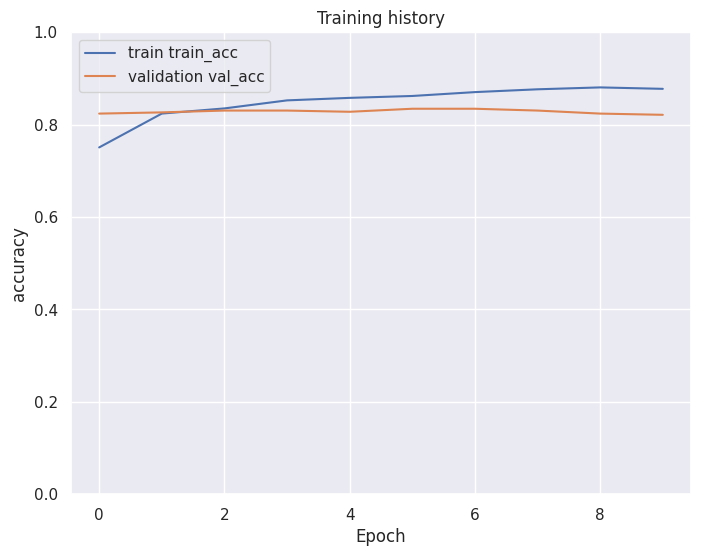

In [120]:
rcParams['figure.figsize'] = 8, 6


plt.plot(history['train_acc'], label='train train_acc')
plt.plot(history['val_acc'], label='validation val_acc')

plt.title('Training history')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

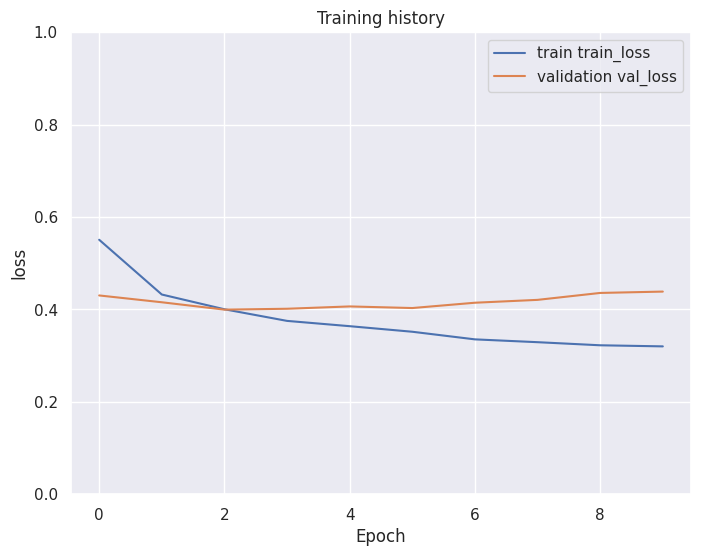

In [121]:


rcParams['figure.figsize'] = 8, 6


plt.plot(history['train_loss'], label='train train_loss')
plt.plot(history['val_loss'], label='validation val_loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [122]:
test_df

,id,keyword,location,target,text_len,text,Topic
751,1083,blew%20up,Indiana,0,99,instagram blew apparently featured jazz tonigh...,-1
5773,8240,riot,NaN,0,137,jwalkerlyle discovered nickcannon listen buy r...,0
6233,8900,snowstorm,"Huntington, WV",0,140,sorry built fire desk already irishirr mchapma...,-1
4536,6450,injured,Tropical SE FLorida,0,131,wakeupflorida floridians likely killed injured...,-1
6915,9916,trouble,Canada,1,88,canagal good hear back storm given guys troubl...,-1
...,...,...,...,...,...,...,...
1632,2358,collapsed,NaN,1,133,way gary chicago entrances closed due bridge c...,101
7219,10338,weapons,"Odawara, Japan",0,118,thing rules break becomes easier next time,74
6455,9235,suicide%20bombing,USA,1,81,turkish troops killed kurdish militant suicide...,-1
5903,8431,sandstorm,USA,1,91,watch airport get swallowed sandstorm minute,118


In [123]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the best model
best_model = SentimentClassifier()
best_model.load_state_dict(torch.load('best_model_state.bin'))
best_model = best_model.to(device)

# Create a DataLoader for the test set
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

# Evaluate the model on the test set
test_acc, test_loss = eval_model(best_model, test_data_loader, loss_fn, device, len(test_df))

print(f'Test loss {test_loss} accuracy {test_acc}')

# Function to get predictions for a DataLoader
def get_predictions(model, data_loader):
    model = model.to(device)
    model.eval()
    
    all_preds = []
    
    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            topics = data['topics'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, topics=topics)
            
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
    
    return all_preds

# Get predictions for the test set
test_predictions = get_predictions(best_model, test_data_loader)

# Calculate metrics
test_targets = test_df['target'].to_numpy()
accuracy = accuracy_score(test_targets, test_predictions)
precision = precision_score(test_targets, test_predictions)
recall = recall_score(test_targets, test_predictions)
f1 = f1_score(test_targets, test_predictions)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Test loss 0.4269437895466884 accuracy 0.8280839895013123
Test Accuracy: 0.8281
Precision: 0.8161
Recall: 0.7737
F1 Score: 0.7943
